
=== Generated 3-factor CCD Matrix (preview) ===
    A_coded  B_coded  C_coded  BFC (%)  Temperature (°C)  Duration (min)  Run
0    -1.000   -1.000   -1.000    0.000            25.000           0.000    1
1     1.000   -1.000   -1.000    1.100            25.000           0.000    2
2    -1.000    1.000   -1.000    0.000           500.000           0.000    3
3     1.000    1.000   -1.000    1.100           500.000           0.000    4
4    -1.000   -1.000    1.000    0.000            25.000         120.000    5
5     1.000   -1.000    1.000    1.100            25.000         120.000    6
6    -1.000    1.000    1.000    0.000           500.000         120.000    7
7     1.000    1.000    1.000    1.100           500.000         120.000    8
8     0.000    0.000    0.000    0.550           262.500          60.000    9
9     0.000    0.000    0.000    0.550           262.500          60.000   10
10    0.000    0.000    0.000    0.550           262.500          60.000   11
11    0.000    

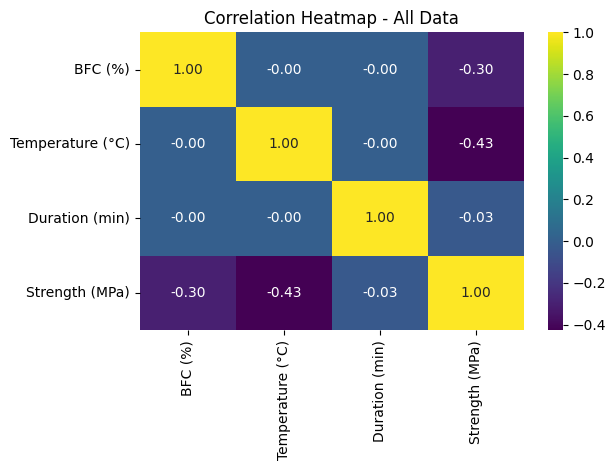


=== Correlation Matrix (Compressive) ===
                  BFC (%)  Temperature (°C)  Duration (min)  Strength (MPa)
BFC (%)             1.000            -0.000          -0.000          -0.496
Temperature (°C)   -0.000             1.000          -0.000          -0.683
Duration (min)     -0.000            -0.000           1.000          -0.034
Strength (MPa)     -0.496            -0.683          -0.034           1.000


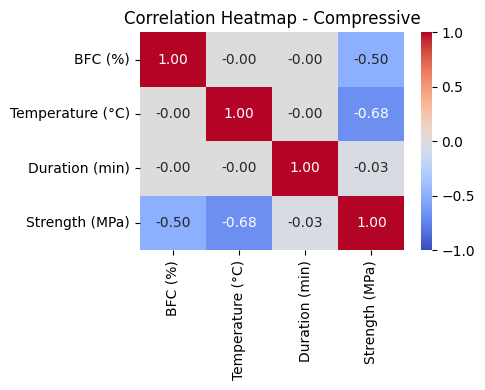


=== Correlation Matrix (Flexural) ===
                  BFC (%)  Temperature (°C)  Duration (min)  Strength (MPa)
BFC (%)             1.000            -0.000          -0.000           0.021
Temperature (°C)   -0.000             1.000          -0.000          -0.386
Duration (min)     -0.000            -0.000           1.000          -0.431
Strength (MPa)      0.021            -0.386          -0.431           1.000


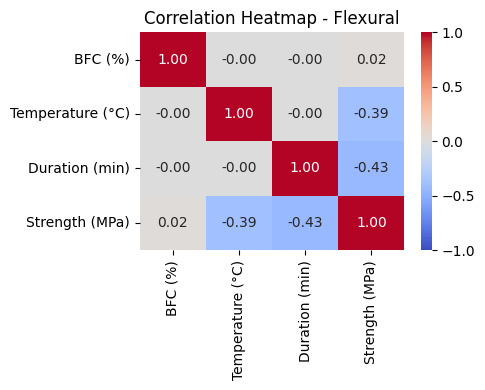

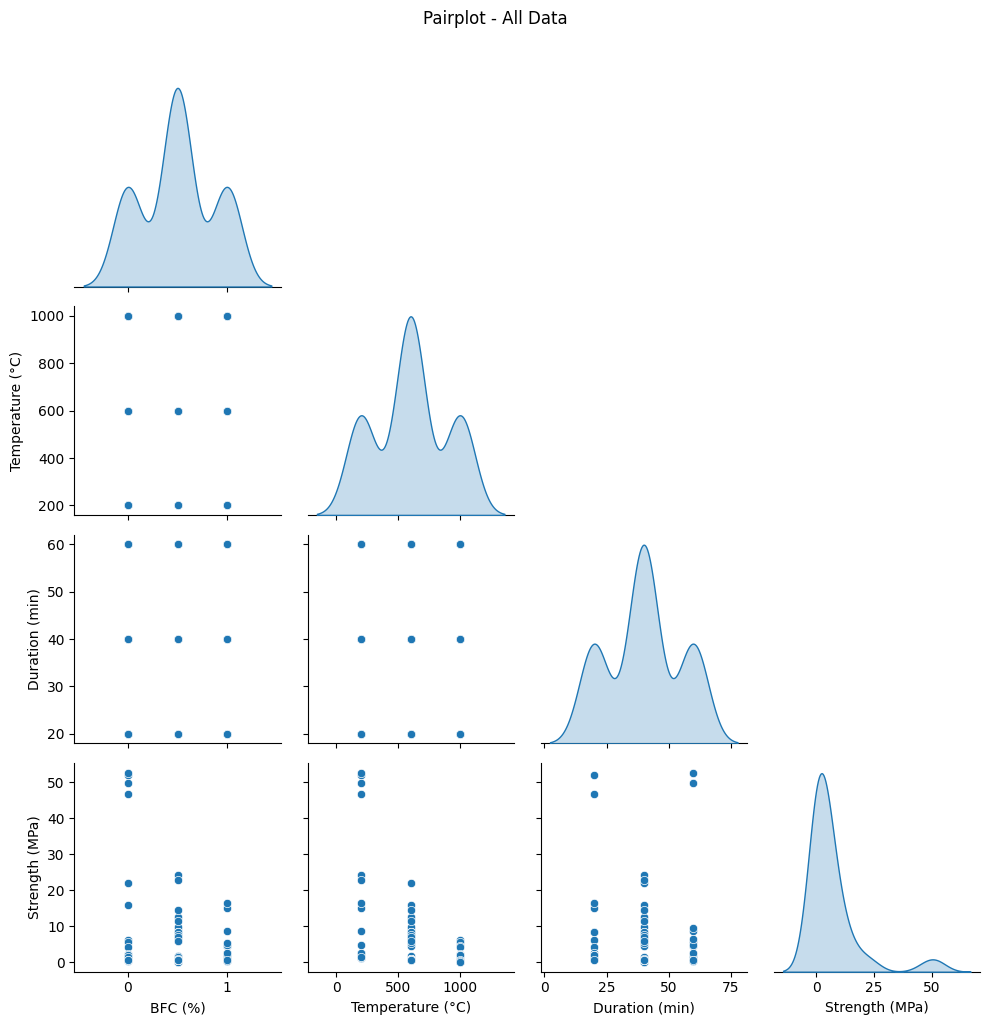

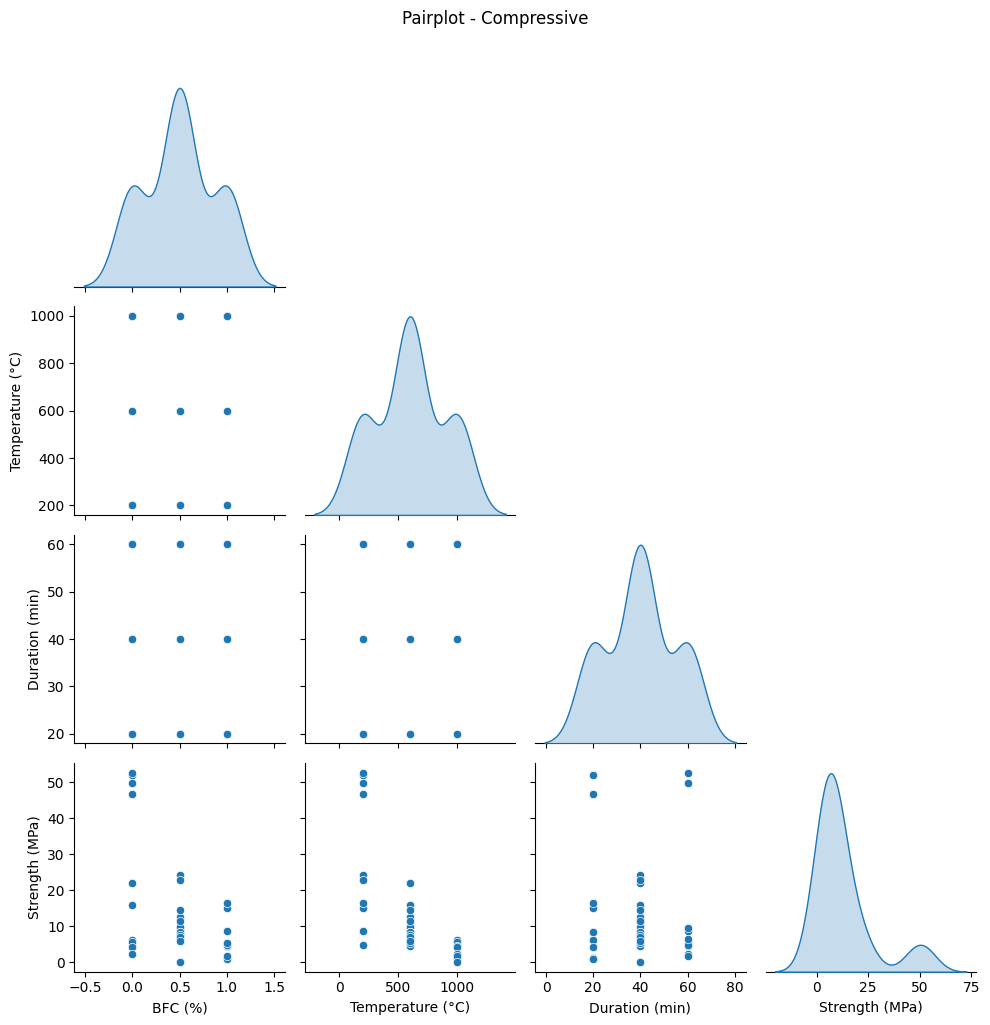

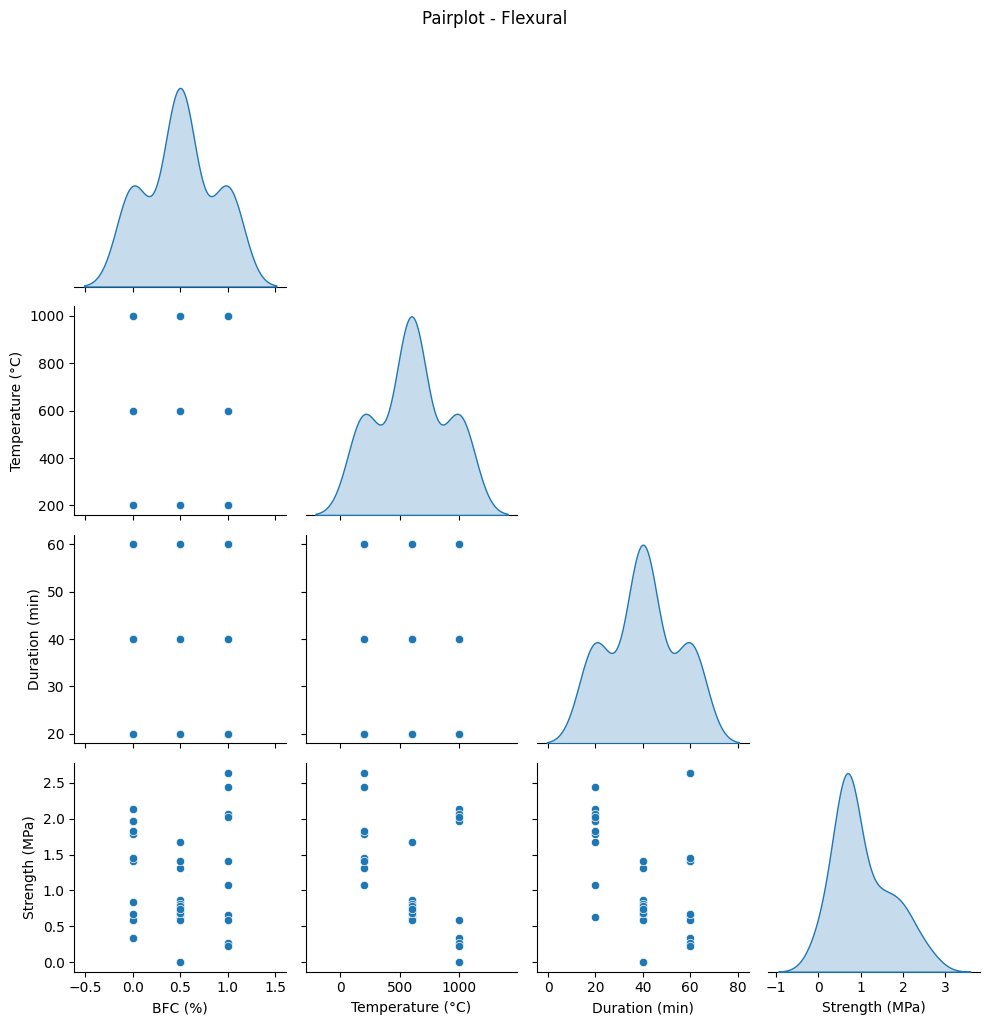


=== Variance Inflation Factor (VIF) — Compressive ===
                              Term      VIF
0                            const  119.080
1                          BFC (%)   23.358
2                 Temperature (°C)   39.977
3                   Duration (min)   63.244
4         BFC (%)*Temperature (°C)    5.062
5           BFC (%)*Duration (min)    7.250
6  Temperature (°C)*Duration (min)    8.813
7                        BFC (%)^2   16.364
8               Temperature (°C)^2   34.545
9                 Duration (min)^2   60.000

--- VIF Interpretation ---
VIF < 5  → Low multicollinearity ✅
5 ≤ VIF < 10 → Moderate multicollinearity ⚠️ (monitor)
VIF ≥ 10 → High multicollinearity ❌ (check correlated predictors)

=== Variance Inflation Factor (VIF) — Flexural ===
                              Term      VIF
0                            const  119.080
1                          BFC (%)   23.358
2                 Temperature (°C)   39.977
3                   Duration (min)   63.244
4    

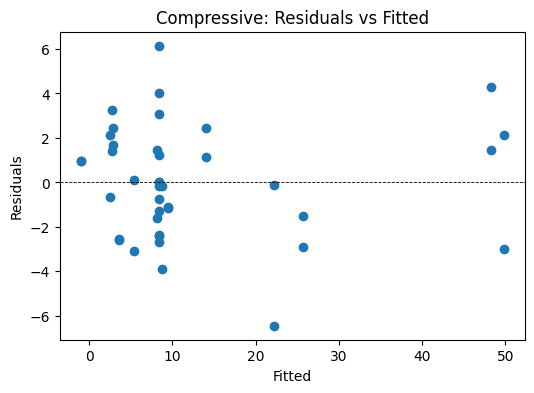

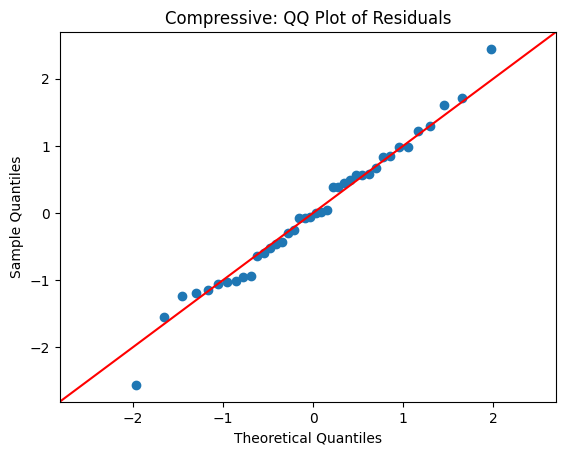

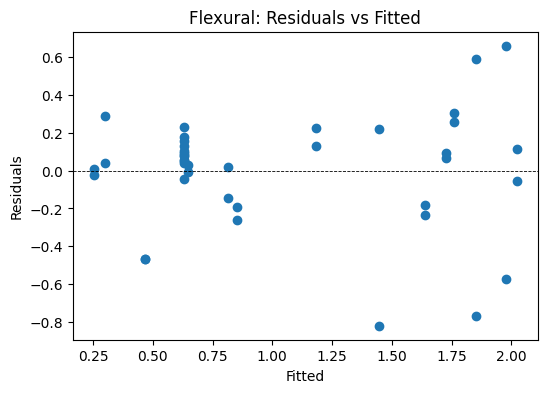

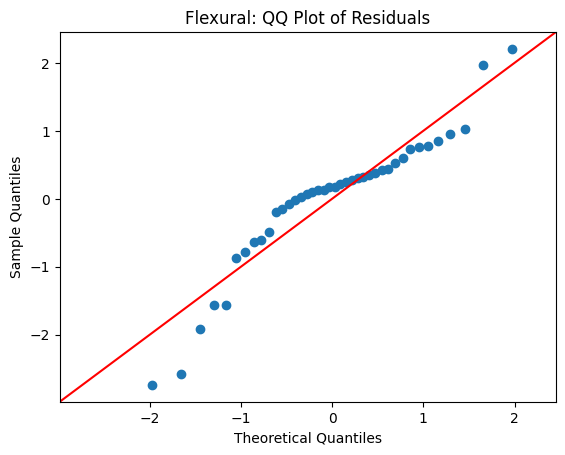


Compressive Optimum: BFC=0.000 %, Temp=160.0 °C, Dur=18.0 min -> Strength=53.137 MPa
Flexural Optimum: BFC=1.050 %, Temp=160.0 °C, Dur=62.0 min -> Strength=2.264 MPa


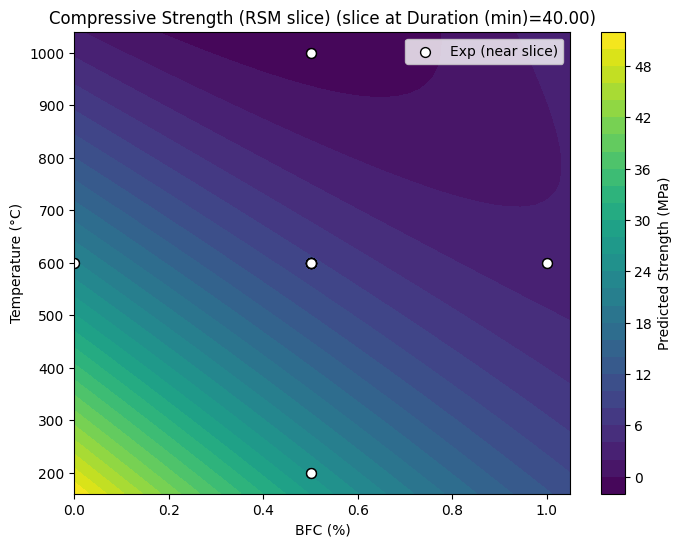

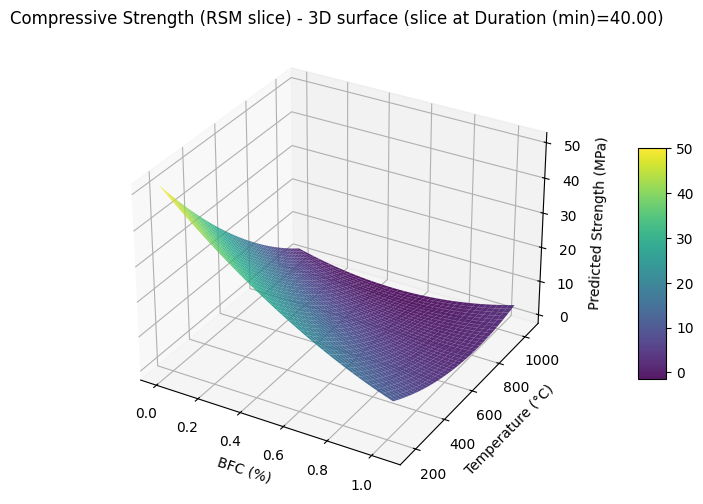

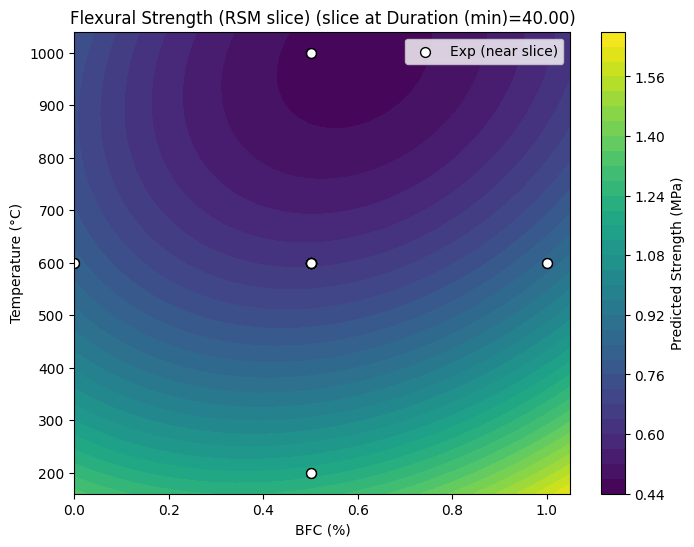

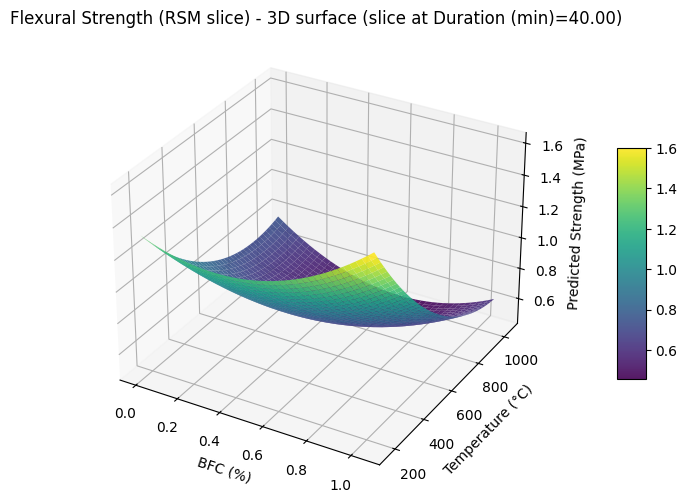


Multi-response optimum (desirability): BFC=0.000 %, Temp=200.0 °C, Dur=20.0 min
 Predicted Compressive = 49.7937 MPa, Flexural = 1.7275 MPa, Desirability = 0.9211
Saved prediction grid to rsm_outputs/3f_prediction_grid_and_desirability.csv

All done. Outputs (plots, CSVs) are in folder: rsm_outputs


In [2]:
# =========================================
# Engr.Jamie Eduardo Rosal, MSCpE 
# RSM + CCD Analysis — 3-Factor (BFC, Temp, Duration)
# Objective:
# Optimize banana fiber content (BFC %), exposure temperature (°C),
# and exposure duration (min) to maximize residual compressive and flexural strength.
# Requirements:
# pip install pandas numpy scipy matplotlib seaborn statsmodels scikit-learn pyDOE2 openpyxl
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import MinMaxScaler
from pyDOE2 import ccdesign
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# -------------------------
# USER CONFIG
# -------------------------
DATA_PATH = "dataset2.xlsx"   # <-- change to your Excel filename
SHEET_NAME = 0
SAVE_FIGS = True
OUT_DIR = "rsm_outputs"
os.makedirs(OUT_DIR, exist_ok=True)
np.set_printoptions(precision=4, suppress=True)

# -------------------------
# 0) Generate 3-factor CCD design (optional template)
# -------------------------
# Default factor bounds (will be overwritten by dataset min/max if present)
BFC_min, BFC_max = 0.0, 1.1         # Fiber %
Temp_min, Temp_max = 25.0, 500.0   # Temperature °C
Dur_min, Dur_max = 0.0, 120.0      # Duration minutes

k = 3  # number of factors
ccd_matrix = ccdesign(k, center=(4,4), face='ccc')  # rotatable CCD
ccd_df = pd.DataFrame(ccd_matrix, columns=['A_coded','B_coded','C_coded'])

# map coded to actual for defaults
ccd_df['BFC (%)'] = (BFC_max - BFC_min)/2 * ccd_df['A_coded'] + (BFC_max + BFC_min)/2
ccd_df['Temperature (°C)'] = (Temp_max - Temp_min)/2 * ccd_df['B_coded'] + (Temp_max + Temp_min)/2
ccd_df['Duration (min)'] = (Dur_max - Dur_min)/2 * ccd_df['C_coded'] + (Dur_max + Dur_min)/2
ccd_df['Run'] = range(1, len(ccd_df)+1)

print("\n=== Generated 3-factor CCD Matrix (preview) ===")
print(ccd_df.round(3).head(len(ccd_df)))

ccd_df.to_excel(f"{OUT_DIR}/CCD_Design_Matrix_3factor.xlsx", index=False)
print(f"\nCCD matrix saved to: {OUT_DIR}/CCD_Design_Matrix_3factor.xlsx")

# -------------------------
# 1) Load dataset (or use CCD template)
# -------------------------
if os.path.exists(DATA_PATH):
    df = pd.read_excel(DATA_PATH, sheet_name=SHEET_NAME)
    df.columns = df.columns.str.strip()
    # override factor bounds if present in data
    if 'BFC (%)' in df.columns and df['BFC (%)'].notna().any():
        BFC_min, BFC_max = float(df['BFC (%)'].min()), float(df['BFC (%)'].max())
    if 'Temperature (°C)' in df.columns and df['Temperature (°C)'].notna().any():
        Temp_min, Temp_max = float(df['Temperature (°C)'].min()), float(df['Temperature (°C)'].max())
    if 'Duration (min)' in df.columns and df['Duration (min)'].notna().any():
        Dur_min, Dur_max = float(df['Duration (min)'].min()), float(df['Duration (min)'].max())
else:
    print("\n⚠️ Dataset not found — using CCD template (no response values).")
    df = ccd_df[['BFC (%)','Temperature (°C)','Duration (min)']].copy()
    df['ID'] = np.arange(1, len(df)+1)
    df['FORCE (kN)'] = np.nan
    df['Strength (MPa)'] = np.nan
    df['Batch type'] = np.nan

# ensure required columns exist
for col in ['ID','FORCE (kN)','Strength (MPa)','BFC (%)','Temperature (°C)','Duration (min)','Batch type']:
    if col not in df.columns:
        df[col] = np.nan

# numeric conversion
for c in ['FORCE (kN)','Strength (MPa)','BFC (%)','Temperature (°C)','Duration (min)']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

print("\nLoaded dataset with rows:", len(df))
print("Columns:", df.columns.tolist())

# -------------------------
# 2) Descriptive statistics (overall, by Batch type, by TestType)
# -------------------------
print("\n=== Descriptive statistics (Overall) ===")
desc_overall = df[['Strength (MPa)','FORCE (kN)','BFC (%)','Temperature (°C)','Duration (min)']].describe().round(4)
print(desc_overall)
desc_overall.to_csv(f"{OUT_DIR}/descriptive_overall.csv")

# compute CV%
def add_cv(df_stats):
    df_stats = df_stats.copy()
    if 'mean' in df_stats.columns and 'std' in df_stats.columns:
        df_stats['CV%'] = (df_stats['std'] / df_stats['mean']).replace([np.inf, -np.inf], np.nan) * 100
    return df_stats

# by Batch type
if 'Batch type' in df.columns and df['Batch type'].notna().any():
    print("\n=== Descriptive statistics by Batch type ===")
    grp = df.groupby('Batch type')['Strength (MPa)'].agg(['count','mean','std','min','max']).round(4)
    grp['CV%'] = (grp['std'] / grp['mean']).replace([np.inf, -np.inf], np.nan) * 100
    print(grp)
    grp.to_csv(f"{OUT_DIR}/descriptive_by_batchtype.csv")
else:
    print("\nNo 'Batch type' data for groupwise descriptive statistics.")

# derive TestType from Batch type
if 'Batch type' in df.columns:
    df['TestType'] = df['Batch type'].apply(lambda x: 'Compressive' if isinstance(x,str) and 'COMPRESS' in x.upper()
                                           else ('Flexural' if isinstance(x,str) and 'FLEX' in x.upper() else 'Other'))
else:
    df['TestType'] = 'Compressive'

print("\n=== Descriptive statistics by TestType ===")
grp2 = df.groupby('TestType')['Strength (MPa)'].agg(['count','mean','std','min','max']).round(4)
grp2['CV%'] = (grp2['std'] / grp2['mean']).replace([np.inf, -np.inf], np.nan) * 100
print(grp2)
grp2.to_csv(f"{OUT_DIR}/descriptive_by_testtype.csv")

# split datasets
comp_df = df[df['TestType']=='Compressive'].dropna(subset=['BFC (%)','Temperature (°C)','Duration (min)']).copy()
flex_df = df[df['TestType']=='Flexural'].dropna(subset=['BFC (%)','Temperature (°C)','Duration (min)']).copy()
print(f"\nCompressive rows: {len(comp_df)} | Flexural rows: {len(flex_df)}")



# ============================================================
# 3) Correlation Analysis and Pairplots
# ============================================================
corr_features = ['BFC (%)', 'Temperature (°C)', 'Duration (min)', 'Strength (MPa)']

# ---- Correlation for full dataset ----
print("\n=== Correlation Matrix (All Data) ===")
corr_all = df[corr_features].corr().round(3)
print(corr_all)
sns.heatmap(corr_all, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap - All Data")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/corr_heatmap_all.png", dpi=300)
plt.show()

# ---- Correlation by Test Type ----
for ttype, dsub in df.groupby('TestType'):
    print(f"\n=== Correlation Matrix ({ttype}) ===")
    corr_mat = dsub[corr_features].corr().round(3)
    print(corr_mat)
    plt.figure(figsize=(5,4))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title(f"Correlation Heatmap - {ttype}")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/corr_heatmap_{ttype.lower()}.png", dpi=300)
    plt.show()

# ---- Pairplots (Scatter Matrix) ----
sns.pairplot(df[corr_features].dropna(), diag_kind="kde", corner=True)
plt.suptitle("Pairplot - All Data", y=1.02)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/pairplot_all.png", dpi=300)
plt.show()

# Pairplots by test type (if enough data)
for ttype, dsub in df.groupby('TestType'):
    if len(dsub) > 5:
        sns.pairplot(dsub[corr_features].dropna(), diag_kind="kde", corner=True)
        plt.suptitle(f"Pairplot - {ttype}", y=1.02)
        plt.tight_layout()
        plt.savefig(f"{OUT_DIR}/pairplot_{ttype.lower()}.png", dpi=300)
        plt.show()


# ============================================================
# 4) Variance Inflation Factor (VIF) Analysis — Multicollinearity Check
# ============================================================
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df_in, f1='BFC (%)', f2='Temperature (°C)', f3='Duration (min)', test_type='Compressive'):
    """Compute VIF for all terms in the quadratic RSM model."""
    print(f"\n=== Variance Inflation Factor (VIF) — {test_type} ===")
    X = build_quadratic_X_3f(df_in, f1, f2, f3)
    vif_data = pd.DataFrame()
    vif_data["Term"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_data = vif_data.round(3)
    print(vif_data)
    vif_data.to_csv(f"{OUT_DIR}/VIF_{test_type.lower()}.csv", index=False)
    
    # Interpretation summary
    print("\n--- VIF Interpretation ---")
    print("VIF < 5  → Low multicollinearity ✅")
    print("5 ≤ VIF < 10 → Moderate multicollinearity ⚠️ (monitor)")
    print("VIF ≥ 10 → High multicollinearity ❌ (check correlated predictors)")
    return vif_data

# Run VIF for each test type (if enough data)
if len(comp_df) > 5:
    vif_comp = compute_vif(comp_df, test_type='Compressive')
if len(flex_df) > 5:
    vif_flex = compute_vif(flex_df, test_type='Flexural')



# -------------------------
# Helper: build quadratic design matrix for 3 factors
# -------------------------
def build_quadratic_X_3f(df_in, f1='BFC (%)', f2='Temperature (°C)', f3='Duration (min)'):
    """Builds a quadratic design matrix for 3-factor RSM modeling."""
    X = pd.DataFrame({'const': np.ones(len(df_in))}, index=df_in.index)
    
    # Linear terms
    X[f1] = df_in[f1]
    X[f2] = df_in[f2]
    X[f3] = df_in[f3]
    
    # Two-way interaction terms
    X[f'{f1}*{f2}'] = df_in[f1] * df_in[f2]
    X[f'{f1}*{f3}'] = df_in[f1] * df_in[f3]
    X[f'{f2}*{f3}'] = df_in[f2] * df_in[f3]
    
    # Quadratic (squared) terms
    X[f'{f1}^2'] = df_in[f1]**2
    X[f'{f2}^2'] = df_in[f2]**2
    X[f'{f3}^2'] = df_in[f3]**2
    
    return X



# -------------------------
# 3) Fit quadratic RSM (OLS) for 3 factors
# -------------------------
def fit_rsm_3f(df_in, response_col='Strength (MPa)', name='Compressive'):
    print(f"\n--- RSM (3F) for {name} (n={len(df_in)}) ---")
    if len(df_in) < 6:
        print(" Not enough runs to fit 3-factor quadratic model. Need more data.")
        return None, None, None
    X = build_quadratic_X_3f(df_in)
    y = df_in[response_col]
    model = sm.OLS(y, X, missing='drop').fit()
    print(model.summary())
    try:
        anova_res = anova_lm(model, typ=2)
        print("\nANOVA (Type II):")
        print(anova_res)
    except Exception as e:
        print("ANOVA error:", e)
    # save coefficients
    coef_df = pd.DataFrame({'term': model.params.index, 'coef': model.params.values, 'pvalue': model.pvalues.values})
    coef_df.to_csv(f"{OUT_DIR}/{name}_3f_model_coefs.csv", index=False)
    return model, X, y

comp_model, comp_X, comp_y = (None, None, None) if len(comp_df)==0 else fit_rsm_3f(comp_df, name='Compressive')
flex_model, flex_X, flex_y = (None, None, None) if len(flex_df)==0 else fit_rsm_3f(flex_df, name='Flexural')

# -------------------------
# 4) Diagnostics (residuals + QQ)
# -------------------------
def diagnostics_plots(model, tag):
    resid = model.resid
    fitted = model.fittedvalues
    plt.figure(figsize=(6,4))
    plt.scatter(fitted, resid)
    plt.axhline(0, color='k', linestyle='--', linewidth=0.6)
    plt.xlabel('Fitted'); plt.ylabel('Residuals')
    plt.title(f'{tag}: Residuals vs Fitted')
    if SAVE_FIGS: plt.savefig(f"{OUT_DIR}/{tag}_resid_vs_fitted.png", dpi=300, bbox_inches='tight')
    plt.show()
    sm.qqplot(resid, line='45', fit=True)
    plt.title(f'{tag}: QQ Plot of Residuals')
    if SAVE_FIGS: plt.savefig(f"{OUT_DIR}/{tag}_qq.png", dpi=300, bbox_inches='tight')
    plt.show()

if comp_model is not None: diagnostics_plots(comp_model, 'Compressive')
if flex_model is not None: diagnostics_plots(flex_model, 'Flexural')

# -------------------------
# 5) Prediction grid & optimization (3D grid)
# -------------------------
def prediction_grid_and_optimize_3f(model, df_in, f1='BFC (%)', f2='Temperature (°C)', f3='Duration (min)', grid_n=41):
    # build grid across observed ranges (expand slightly)
    f1_min, f1_max = df_in[f1].min(), df_in[f1].max()
    f2_min, f2_max = df_in[f2].min(), df_in[f2].max()
    f3_min, f3_max = df_in[f3].min(), df_in[f3].max()
    pad1 = (f1_max - f1_min) * 0.05 if f1_max>f1_min else 0.01
    pad2 = (f2_max - f2_min) * 0.05 if f2_max>f2_min else 1.0
    pad3 = (f3_max - f3_min) * 0.05 if f3_max>f3_min else 1.0
    f1_vals = np.linspace(max(0,f1_min-pad1), f1_max+pad1, grid_n)
    f2_vals = np.linspace(max(0,f2_min-pad2), f2_max+pad2, grid_n)
    f3_vals = np.linspace(max(0,f3_min-pad3), f3_max+pad3, grid_n)
    # build 3D grid and predict (we will predict on flattened DF)
    F1, F2, F3 = np.meshgrid(f1_vals, f2_vals, f3_vals, indexing='xy')
    DF = pd.DataFrame({
        'const': 1.0,
        f1: F1.ravel(),
        f2: F2.ravel(),
        f3: F3.ravel(),
        f'{f1}*{f2}': (F1*F2).ravel(),
        f'{f1}*{f3}': (F1*F3).ravel(),
        f'{f2}*{f3}': (F2*F3).ravel(),
        f'{f1}^2': (F1**2).ravel(),
        f'{f2}^2': (F2**2).ravel(),
        f'{f3}^2': (F3**2).ravel()
    })
    preds = model.predict(DF)
    preds_mat = preds.values.reshape(F1.shape)
    # find maximum
    idx = np.unravel_index(np.nanargmax(preds_mat), preds_mat.shape)
    opt_f1 = F1[idx]; opt_f2 = F2[idx]; opt_f3 = F3[idx]
    opt_pred = preds_mat[idx]
    # also return entire grid arrays for further slicing/plotting
    return (F1, F2, F3, preds_mat, opt_f1, opt_f2, opt_f3, opt_pred)

if comp_model is not None:
    comp_F1, comp_F2, comp_F3, comp_pred, comp_opt_f1, comp_opt_f2, comp_opt_f3, comp_opt_pred = prediction_grid_and_optimize_3f(comp_model, comp_df)
    print(f"\nCompressive Optimum: BFC={comp_opt_f1:.3f} %, Temp={comp_opt_f2:.1f} °C, Dur={comp_opt_f3:.1f} min -> Strength={comp_opt_pred:.3f} MPa")
if flex_model is not None:
    flex_F1, flex_F2, flex_F3, flex_pred, flex_opt_f1, flex_opt_f2, flex_opt_f3, flex_opt_pred = prediction_grid_and_optimize_3f(flex_model, flex_df)
    print(f"Flexural Optimum: BFC={flex_opt_f1:.3f} %, Temp={flex_opt_f2:.1f} °C, Dur={flex_opt_f3:.1f} min -> Strength={flex_opt_pred:.3f} MPa")

# -------------------------
# 5B) RSM plots: slices at center of third factor
# -------------------------
def plot_rsm_slice(F1, F2, F3, pred_mat, df_exp, f1label, f2label, f3label, title_prefix, prefix, save=True):
    # determine middle index along third axis for slice
    mid_idx = F3.shape[2] // 2
    slice_pred = pred_mat[:,:,mid_idx]
    slice_f3_value = float(F3[0,0,mid_idx])
    # 2D contour plot
    plt.figure(figsize=(8,6))
    cs = plt.contourf(F1[:,:,mid_idx], F2[:,:,mid_idx], slice_pred, levels=30, cmap='viridis')
    plt.colorbar(cs, label='Predicted Strength (MPa)')
    plt.xlabel(f1label); plt.ylabel(f2label)
    plt.title(f"{title_prefix} (slice at {f3label}={slice_f3_value:.2f})")
    if df_exp is not None:
        # overlay experiments near this slice (tolerance)
        tol = (F3.max()-F3.min())/ (F3.shape[2]) * 1.5
        mask = np.abs(df_exp[f3label] - slice_f3_value) <= tol
        if mask.any():
            plt.scatter(df_exp.loc[mask, f1label], df_exp.loc[mask, f2label], c='white', edgecolor='k', s=50, label='Exp (near slice)')
            plt.legend()
    if save: plt.savefig(f"{OUT_DIR}/{prefix}_contour_slice.png", dpi=300, bbox_inches='tight')
    plt.show()

    # 3D surface (slice)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(F1[:,:,mid_idx], F2[:,:,mid_idx], slice_pred, cmap=cm.viridis, linewidth=0, antialiased=True, alpha=0.9)
    ax.set_xlabel(f1label); ax.set_ylabel(f2label); ax.set_zlabel('Predicted Strength (MPa)')
    ax.set_title(f"{title_prefix} - 3D surface (slice at {f3label}={slice_f3_value:.2f})")
    fig.colorbar(surf, shrink=0.5, aspect=8, pad=0.1)
    if save: plt.savefig(f"{OUT_DIR}/{prefix}_3Dslice.png", dpi=300, bbox_inches='tight')
    plt.show()

# create slices using the grids returned earlier
if comp_model is not None:
    plot_rsm_slice(comp_F1, comp_F2, comp_F3, comp_pred, comp_df, 'BFC (%)','Temperature (°C)','Duration (min)',
                   'Compressive Strength (RSM slice)', 'compressive')
if flex_model is not None:
    plot_rsm_slice(flex_F1, flex_F2, flex_F3, flex_pred, flex_df, 'BFC (%)','Temperature (°C)','Duration (min)',
                   'Flexural Strength (RSM slice)', 'flexural')

# -------------------------
# 6) Multi-response desirability optimization over 3 factors
# -------------------------
if comp_model is not None and flex_model is not None:
    # use union of ranges
    u_f1_min, u_f1_max = min(comp_df['BFC (%)'].min(), flex_df['BFC (%)'].min()), max(comp_df['BFC (%)'].max(), flex_df['BFC (%)'].max())
    u_f2_min, u_f2_max = min(comp_df['Temperature (°C)'].min(), flex_df['Temperature (°C)'].min()), max(comp_df['Temperature (°C)'].max(), flex_df['Temperature (°C)'].max())
    u_f3_min, u_f3_max = min(comp_df['Duration (min)'].min(), flex_df['Duration (min)'].min()), max(comp_df['Duration (min)'].max(), flex_df['Duration (min)'].max())
    # small fallback
    if np.isnan(u_f1_min): u_f1_min,u_f1_max = BFC_min,BFC_max
    if np.isnan(u_f2_min): u_f2_min,u_f2_max = Temp_min,Temp_max
    if np.isnan(u_f3_min): u_f3_min,u_f3_max = Dur_min,Dur_max

    F1u = np.linspace(u_f1_min, u_f1_max, 41)
    F2u = np.linspace(u_f2_min, u_f2_max, 41)
    F3u = np.linspace(u_f3_min, u_f3_max, 21)
    F1uG, F2uG, F3uG = np.meshgrid(F1u, F2u, F3u, indexing='xy')
    DFu = pd.DataFrame({
        'const': 1.0,
        'BFC (%)': F1uG.ravel(),
        'Temperature (°C)': F2uG.ravel(),
        'Duration (min)': F3uG.ravel(),
        'BFC (%)*Temperature (°C)': (F1uG*F2uG).ravel(),
        'BFC (%)*Duration (min)': (F1uG*F3uG).ravel(),
        'Temperature (°C)*Duration (min)': (F2uG*F3uG).ravel(),
        'BFC (%)^2': (F1uG**2).ravel(),
        'Temperature (°C)^2': (F2uG**2).ravel(),
        'Duration (min)^2': (F3uG**2).ravel()
    })
    pred_comp_u = comp_model.predict(DFu)
    pred_flex_u = flex_model.predict(DFu)
    scaler = MinMaxScaler()
    d1 = scaler.fit_transform(pred_comp_u.values.reshape(-1,1)).ravel()
    d2 = scaler.fit_transform(pred_flex_u.values.reshape(-1,1)).ravel()
    desir = np.sqrt(d1*d2 + 1e-8)
    desir_mat = desir.reshape(F1uG.shape)
    idx = np.unravel_index(np.nanargmax(desir_mat), desir_mat.shape)
    opt_bfc_multi = F1uG[idx]; opt_temp_multi = F2uG[idx]; opt_dur_multi = F3uG[idx]
    opt_comp_at_multi = pred_comp_u.values.reshape(F1uG.shape)[idx]
    opt_flex_at_multi = pred_flex_u.values.reshape(F1uG.shape)[idx]
    opt_desir = desir_mat[idx]
    print(f"\nMulti-response optimum (desirability): BFC={opt_bfc_multi:.3f} %, Temp={opt_temp_multi:.1f} °C, Dur={opt_dur_multi:.1f} min")
    print(f" Predicted Compressive = {opt_comp_at_multi:.4f} MPa, Flexural = {opt_flex_at_multi:.4f} MPa, Desirability = {opt_desir:.4f}")

    # save grid to csv (may be large)
    out_grid = pd.DataFrame({
        'BFC (%)': DFu['BFC (%)'],
        'Temperature (°C)': DFu['Temperature (°C)'],
        'Duration (min)': DFu['Duration (min)'],
        'Pred_Compressive': pred_comp_u,
        'Pred_Flexural': pred_flex_u,
        'Desirability': desir
    })
    out_grid.to_csv(f"{OUT_DIR}/3f_prediction_grid_and_desirability.csv", index=False)
    print(f"Saved prediction grid to {OUT_DIR}/3f_prediction_grid_and_desirability.csv")

# -------------------------
# 7) Save model summaries and coefficient files
# -------------------------
if comp_model is not None:
    comp_coef = pd.DataFrame({'term': comp_model.params.index, 'coef': comp_model.params.values, 'pvalue': comp_model.pvalues.values})
    comp_coef.to_csv(f"{OUT_DIR}/compressive_3f_model_coefs.csv", index=False)
if flex_model is not None:
    flex_coef = pd.DataFrame({'term': flex_model.params.index, 'coef': flex_model.params.values, 'pvalue': flex_model.pvalues.values})
    flex_coef.to_csv(f"{OUT_DIR}/flexural_3f_model_coefs.csv", index=False)

print("\nAll done. Outputs (plots, CSVs) are in folder:", OUT_DIR)


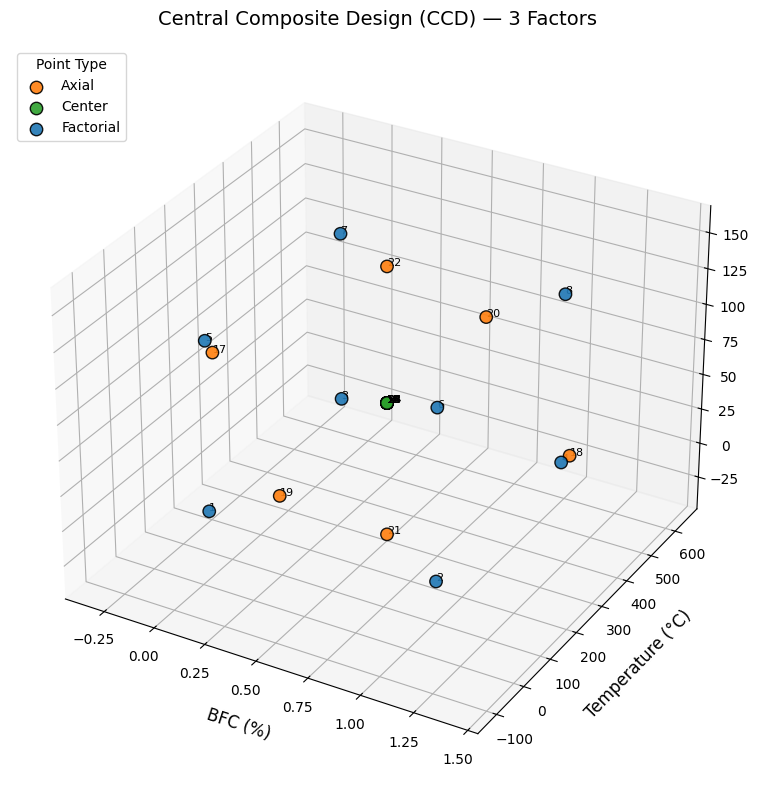


=== Central Composite Design (CCD) Matrix ===
    Run  A_coded  B_coded  C_coded  BFC (%)  Temperature (°C)  Duration (min)  \
0     1   -1.000   -1.000   -1.000     0.00             25.00           0.000   
1     2    1.000   -1.000   -1.000     1.10             25.00           0.000   
2     3   -1.000    1.000   -1.000     0.00            500.00           0.000   
3     4    1.000    1.000   -1.000     1.10            500.00           0.000   
4     5   -1.000   -1.000    1.000     0.00             25.00         120.000   
5     6    1.000   -1.000    1.000     1.10             25.00         120.000   
6     7   -1.000    1.000    1.000     0.00            500.00         120.000   
7     8    1.000    1.000    1.000     1.10            500.00         120.000   
8     9    0.000    0.000    0.000     0.55            262.50          60.000   
9    10    0.000    0.000    0.000     0.55            262.50          60.000   
10   11    0.000    0.000    0.000     0.55            262.50 

In [3]:
# =========================================
# 3D Central Composite Design Visualization
# =========================================
# Requirements:
# pip install numpy pandas matplotlib pyDOE2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyDOE2 import ccdesign

# -------------------------
# Factor Ranges
# -------------------------
BFC_min, BFC_max = 0.0, 1.1          # Banana Fiber Content (%)
Temp_min, Temp_max = 25, 500         # Temperature (°C)
Dur_min, Dur_max = 0, 120            # Duration (min)
alpha = 1.825741858                  # axial distance for rotatable design

# -------------------------
# Generate CCD Matrix
# -------------------------
ccd = ccdesign(3, center=(8, 4), face='ccc')  # 3 factors, rotatable
ccd_df = pd.DataFrame(ccd, columns=['A_coded','B_coded','C_coded'])

# Decode to actual units
ccd_df['BFC (%)'] = (BFC_max - BFC_min)/2 * ccd_df['A_coded'] + (BFC_max + BFC_min)/2
ccd_df['Temperature (°C)'] = (Temp_max - Temp_min)/2 * ccd_df['B_coded'] + (Temp_max + Temp_min)/2
ccd_df['Duration (min)'] = (Dur_max - Dur_min)/2 * ccd_df['C_coded'] + (Dur_max + Dur_min)/2
ccd_df['Run'] = np.arange(1, len(ccd_df)+1)

# Identify Design Points
def classify_point(row):
    if all(abs(row[['A_coded','B_coded','C_coded']]) == 1):
        return "Factorial"
    elif any(abs(row[['A_coded','B_coded','C_coded']]) > 1.4):
        return "Axial"
    elif all(abs(row[['A_coded','B_coded','C_coded']]) < 0.1):
        return "Center"
    else:
        return "Other"

ccd_df['Point Type'] = ccd_df.apply(classify_point, axis=1)

# -------------------------
# 3D Visualization
# -------------------------
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

# Plot by category
colors = {'Factorial':'#1f77b4', 'Axial':'#ff7f0e', 'Center':'#2ca02c', 'Other':'gray'}
for key, grp in ccd_df.groupby('Point Type'):
    ax.scatter(grp['BFC (%)'], grp['Temperature (°C)'], grp['Duration (min)'],
               color=colors[key], s=80, label=key, edgecolor='k', alpha=0.9)

# Label a few key runs
for _, row in ccd_df.iterrows():
    ax.text(row['BFC (%)'], row['Temperature (°C)'], row['Duration (min)'],
            f"{int(row['Run'])}", fontsize=8, color='black')

# Formatting
ax.set_xlabel('BFC (%)', fontsize=12, labelpad=10)
ax.set_ylabel('Temperature (°C)', fontsize=12, labelpad=10)
ax.set_zlabel('Duration (min)', fontsize=12, labelpad=10)
ax.set_title('Central Composite Design (CCD) — 3 Factors', fontsize=14, pad=15)

ax.legend(title='Point Type', loc='upper left', fontsize=10)
ax.grid(True)

# Save and show
plt.tight_layout()
plt.savefig("ccd_design_3D.png", dpi=300)
plt.show()

# -------------------------
# Print and Save the CCD Table
# -------------------------
print("\n=== Central Composite Design (CCD) Matrix ===")
print(ccd_df[['Run','A_coded','B_coded','C_coded','BFC (%)','Temperature (°C)','Duration (min)','Point Type']].round(3))
ccd_df.to_excel("ccd_design_matrix_full.xlsx", index=False)
print("\nSaved CCD design matrix to 'ccd_design_matrix_full.xlsx'")
